In [ ]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.stats import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_Tmean = Experiment(
    "ERA5", "t", "dailymean", (1940, 2023), [5, 6, 7, 8, 9], -30, 40, 30, 75, 100, 'dayofyear', {'dayofyear': ('win', 10)}, None
)
da_Tmean = exp_Tmean.da
da_Tmean = da_Tmean.assign_coords(time=da_Tmean.time.values - pd.Timedelta(9, 'H'))

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)

In [ ]:
mask = get_land_mask()
lon, lat = da_Tmean.lon.values, da_Tmean.lat.values
mask = mask.sel(lon=lon, lat=lat)

In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram

JA_mask = np.isin(da_Tmean.time.dt.month, [7, 8])
hot_days = da_Tmean[JA_mask] > da_Tmean[JA_mask].quantile(0.95, dim='time')
stack_dims = {'lat_lon': ('lat', 'lon')}
hot_days_flat = hot_days.stack(stack_dims)
mask_flat = mask.stack(stack_dims)
hot_days_flat = hot_days_flat.values[:, mask_flat.values]
try:
    distances = np.load('results/chiemvs/distances.npy')
except FileNotFoundError:
    print('Computing distances')
    distances = pairwise_distances(hot_days_flat.T, metric='jaccard', n_jobs=-1)
    np.save('results/chiemvs/distances.npy', distances)
Z = linkage(squareform(distances), method='average')

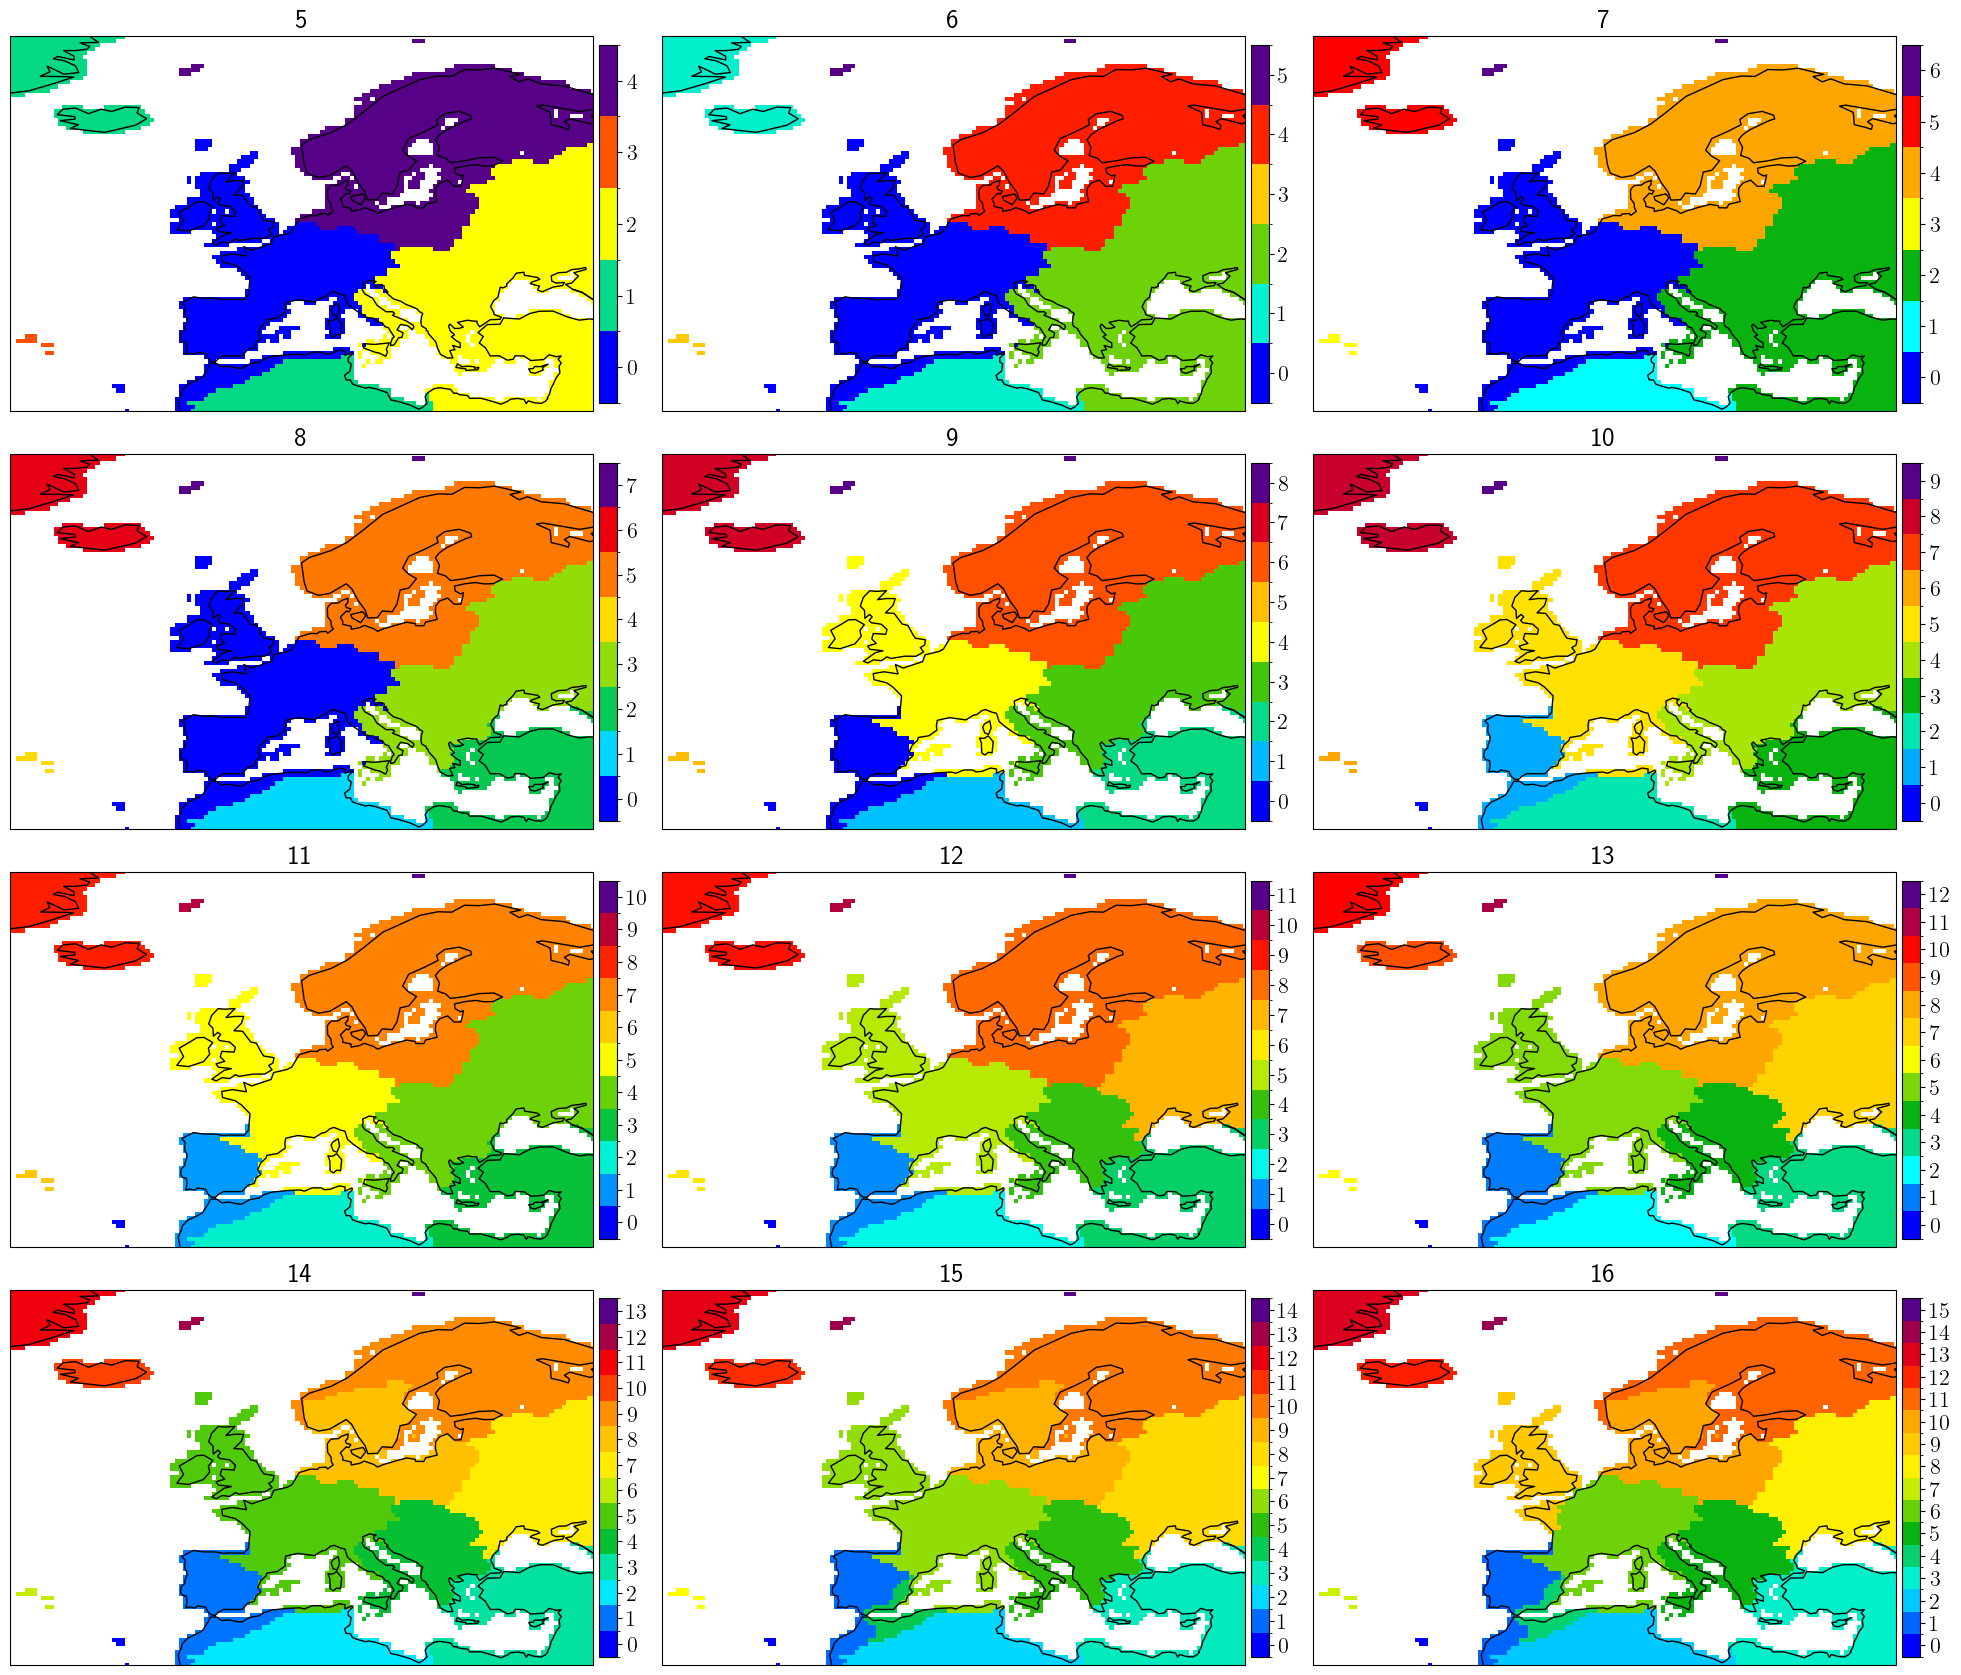

In [ ]:
clu = Clusterplot(4, 3, get_region(mask))
cmap = colormaps.BlAqGrYeOrReVi200
for i, n_clu in enumerate(range(5, 17)):
    clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
    clusters_da = np.zeros(mask_flat.shape, dtype=float)
    clusters_da[:] = np.nan
    clusters_da = mask_flat.copy(data=clusters_da)
    clusters_da[mask_flat] = clusters
    unique_clusters = np.unique(clusters)
    norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
    every = n_clu // 20 + 1
    clusters_da.unstack().plot(
        ax=clu.axes[i],
        cmap=cmap,
        add_colorbar=False,
        add_labels=False
    )
    clu.axes[i].set_title(n_clu)
    im = ScalarMappable(cmap=cmap, norm=norm)
    clu.fig.colorbar(im, ax=clu.axes[i], ticks=np.arange(0, n_clu, every), shrink=0.92, pad=0.01)

### Create drivers and targets

In [ ]:
n_clu = 9
subset = ['Lat', 'Lon', 'Spe', 'lon_ext', 'width', 'tilt', 'sinuosity', 'int', 'persistence']
clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
clusters_da = np.zeros(mask_flat.shape, dtype=float)
clusters_da[:] = np.nan
clusters_da = mask_flat.copy(data=clusters_da)
clusters_da[mask_flat] = clusters
central_europe = clusters_da.where(clusters_da==4).unstack()
da_cee = da_Tmean.where(central_europe).mean(dim=['lon', 'lat']).copy()
timescales = [1, 3, 5, 7, 15, 30]
lags = [0, 1, 3, 5, 7, 15, 30]

props_as_ds_daily = props_as_ds[subset].resample(time='1D').mean(skipna=True).sel(time=da_cee.time.values)
props_as_ds_detrended = props_as_ds_daily.copy()
for varname in props_as_ds_daily.data_vars:
    props_as_ds_daily[varname] = props_as_ds_daily[varname].fillna(DEFAULT_VALUES[varname])    
    props_as_ds_detrended[varname] = xrft.detrend(props_as_ds_daily[varname], dim='time', detrend_type='linear')
props_as_da_daily = props_as_ds_daily.to_array(dim='varname', name='predictors')
props_as_da_detrended = props_as_ds_detrended.to_array(dim='varname', name='predictors')
props_as_da_daily = props_as_da_daily.expand_dims(axis=-1, **dict(timescale=timescales)).copy(deep=True)
props_as_da_detrended = props_as_da_detrended.expand_dims(axis=-1, **dict(timescale=timescales)).copy(deep=True)
da_cee = da_cee.expand_dims(axis=1, **dict(timescale=timescales)).copy(deep=True)
da_Tmean_detrended = xrft.detrend(da_Tmean, dim='time', detrend_type='linear').expand_dims(axis=1, **dict(timescale=timescales)).copy(deep=True)

for n_days in tqdm(timescales[1:]):
    for year in np.unique(da_cee.time.dt.year):
        year_mask = da_cee.time.dt.year == year
        da_cee.loc[year_mask, n_days] = da_cee.loc[year_mask, 1].rolling(time=n_days, center=False).mean().shift(time=-n_days + 1)
        da_Tmean_detrended.loc[year_mask, n_days, ...] = da_Tmean_detrended.loc[year_mask, 1, ...].rolling(time=n_days, center=False).mean().shift(time=-n_days + 1)
        props_as_da_daily.loc[:, year_mask, :, n_days] = props_as_da_daily.loc[:, year_mask, :, n_days].rolling(time=n_days, center=False).mean()

100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


### Find response regions to jet indices

In [ ]:
def stacked_lstsq(L, b, rcond=1e-10): # https://stackoverflow.com/questions/30442377/how-to-solve-many-overdetermined-systems-of-linear-equations-using-vectorized-co
    """
    Solve L x = b, via SVD least squares cutting of small singular values
    L is an array of shape (..., M, N) and b of shape (..., M).
    Returns x of shape (..., N)
    """
    u, s, v = np.linalg.svd(L, full_matrices=False)
    s_max = s.max(axis=-1, keepdims=True)
    s_min = rcond*s_max
    inv_s = np.zeros_like(s)
    inv_s[s >= s_min] = 1/s[s>=s_min]
    x = np.einsum('...ji,...j->...i', v, inv_s * np.einsum('...ji,...j->...i', u, b.conj()))
    return np.conj(x, x)


def create_all_triplets(props_as_da, response_da):
    triplets = []
    for varname in props_as_da.varname.values:
        for jet, n_days, lag in product(props_as_da.jet.values, timescales, lags):
            try:
                driver = props_as_da.loc[varname, :, jet, n_days]
            except IndexError:
                driver = props_as_ds.loc[varname, :, n_days]
            response = response_da.loc[:, n_days, :, :]
            triplets.append(((varname, jet, n_days, lag), driver, response))
    return triplets


def compute_r(triplet):
    (varname, jet, n_days, lag), driver_, response_ = triplet
    drivers, responses = [], []
    for year in YEARSPL:
        slice_ = slice(pd.Timestamp(year, 6, 1), pd.Timestamp(year, 9, 1))
        driver = driver_.loc[slice_].values
        response = response_.loc[slice_].values
        response = response.reshape(response.shape[0], -1)
        response_resid = stacked_lstsq(response[n_days:, None], response[:-n_days])
        response[:-n_days] = response[:-n_days] - response[n_days:] * response_resid
        response = response.reshape(response.shape[0], *da_Tmean_detrended.shape[-2:])
        driver_resid = np.linalg.lstsq(driver[n_days:, None], driver[:-n_days], rcond=None)[0][0]
        driver[:-n_days] = driver[:-n_days] - driver[n_days:] * driver_resid
        driver = np.nan_to_num(driver, DEFAULT_VALUES[varname])
        if lag > 0:
            driver = driver[lag:]
            response = response[:-lag]
        drivers.append(driver)
        responses.append(response)
    driver = np.concatenate(drivers, axis=0)
    response = np.concatenate(responses, axis=0)
    r = np.sum(driver[:, None, None] * response, axis=0) / np.sqrt(np.sum(driver[:, None, None] ** 2, axis=0) * np.sum(response ** 2, axis=0))
    return r

try:
    corr_da = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/corr_da.nc')
except FileNotFoundError:
    coords = {
        'varname': props_as_da_detrended.varname.values,
        'jet': props_as_da_detrended.jet.values,
        'timescale': timescales,
        'lag': lags,
        'lat': da_Tmean_detrended.lat.values,
        'lon': da_Tmean_detrended.lon.values,
    }
    corr_da = xr.DataArray(np.zeros([len(c) for c in coords.values()]), coords=coords)
    corr_da.assign_coords(pstar=('timescale', 5 * 10 ** (-2 - 0.3 * (corr_da.timescale.values - 1))))
    triplets = create_all_triplets(props_as_da_detrended, da_Tmean_detrended)
    with Pool(processes=8) as pool:
        all_r = list(tqdm(pool.imap(compute_r, triplets, chunksize=5), total=len(triplets),))
    all_r = np.asarray(all_r)
    triplet_params = np.asarray([triplet[0] for triplet in triplets])
    newshape = [len(np.unique(triplet_param)) for triplet_param in triplet_params.T]
    all_r = all_r.reshape(*newshape, *all_r[0].shape)
    corr_da[:] = all_r
        
    corr_da.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/corr_da.nc')

100%|██████████| 756/756 [17:03<00:00,  1.35s/it]


### Prediction task for CEE

In [ ]:
from sklearn.metrics import brier_score_loss
da_cee_targets = da_cee > da_cee.quantile(0.66, dim='time')
da_cee_targets = da_cee_targets.sel(time=JA_mask, timescale=[7, 15, 30])
base_pred = da_cee_targets.copy(data=np.zeros(da_cee_targets.shape, dtype=float))
base_pred = base_pred.assign_coords(
    f1_score=        ('timescale', np.zeros(len(base_pred.timescale))),
    roc_score=       ('timescale', np.zeros(len(base_pred.timescale))),
    accuracy=        ('timescale', np.zeros(len(base_pred.timescale))),
    brier_score_loss=('timescale', np.zeros(len(base_pred.timescale))),
)
X_base = (da_cee_targets.time.values - da_cee_targets.time.values[0]).astype('timedelta64[D]').astype(int)[:, None]
for timescale in da_cee_targets.timescale.values:
    y = da_cee_targets.loc[:, timescale].values
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2) 
    lr = LogisticRegression(class_weight=None).fit(X_train, y_train)
    y_pred_prob = lr.predict_proba(X_test)[:, 1]
    y_pred = lr.predict(X_test)
    base_pred.loc[:, timescale] = lr.predict_proba(X_base)[:, 1]
    base_pred.roc_score.loc[timescale] = roc_auc_score(y_test, y_pred_prob)
    base_pred.brier_score_loss.loc[timescale] = brier_score_loss(y_test, y_pred_prob)
    base_pred.f1_score.loc[timescale] = f1_score(y_test, y_pred)
    base_pred.accuracy.loc[timescale] = balanced_accuracy_score(y_test, y_pred)

In [ ]:
props_as_da_lagged = props_as_da_daily.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True)
for lag in lags[1:]:
    for year in np.unique(props_as_da_lagged.time.dt.year):
        year_mask = props_as_da_lagged.time.dt.year == year
        props_as_da_lagged.loc[:, year_mask, :, :, lag] = props_as_da_lagged.loc[:, year_mask, :, :, lag].shift(time=lag)
props_as_da_lagged_stacked = props_as_da_lagged.stack(predictor=('varname', 'jet', 'timescale'))
newindex = ['_'.join([str(t) for t in ts]) for ts in props_as_da_lagged_stacked.predictor.values]
props_as_da_lagged_stacked = props_as_da_lagged_stacked.drop_vars(['timescale', 'varname', 'predictor', 'jet']).assign_coords(predictor=newindex)
props_as_da_lagged_stacked = props_as_da_lagged_stacked[JA_mask]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

targets = da_cee_targets - base_pred
full_pred = da_cee_targets.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True).astype(float)
full_pred[:] = 0
full_pred = full_pred.assign_coords(
    f1_score=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    roc_score=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    accuracy=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    brier_score_loss=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
)
coords = {
    'varname': props_as_da_lagged.varname.values,
    'jet': props_as_da_lagged.jet.values,
    'driver_timescale': props_as_da_lagged.timescale.values,
    'target_timescale': full_pred.timescale.values,
    'lag': full_pred.lag.values,
}
permutation_importances = xr.DataArray(np.zeros([len(c) for c in coords.values()]), coords=coords)
shap_importances = {}
for timescale, lag in tqdm(product(targets.timescale.values, lags), total=len(targets.timescale.values) * len(lags)):
    if timescale not in shap_importances:
        shap_importances[timescale] = {}
    # timescale of target, lag of driver 
    y_orig = da_cee_targets.loc[:, timescale]
    y = targets.loc[:, timescale]
    X = props_as_da_lagged_stacked.sel(lag=lag).values
    X_train, X_test, y_train, y_test, _, y_orig_test, _, idx_test = train_test_split(X, y, y_orig, np.arange(base_pred.shape[0]), test_size=0.2) 
    rfr = RandomForestRegressor(max_depth=10, n_jobs=N_WORKERS).fit(X_train, y_train)
    y_pred_prob = rfr.predict(X_test) + base_pred.loc[:, timescale].values[idx_test]
    y_pred_prob = np.clip(y_pred_prob, 0, 1)
    y_pred = y_pred_prob > 0.5
    full_pred.loc[:, timescale, lag] = rfr.predict(X) + base_pred.loc[:, timescale]
    full_pred.roc_score.loc[timescale, lag] = roc_auc_score(y_orig_test, y_pred_prob)
    full_pred.brier_score_loss.loc[timescale, lag] = brier_score_loss(y_orig_test, y_pred_prob)
    full_pred.f1_score.loc[timescale, lag] = f1_score(y_orig_test, y_pred)
    full_pred.accuracy.loc[timescale, lag] = balanced_accuracy_score(y_orig_test, y_pred)
    r = permutation_importance(rfr, X_test, y_test, n_repeats=30, random_state=0, n_jobs=N_WORKERS)
    r = r.importances_mean.reshape(permutation_importances.shape[:3])
    permutation_importances.loc[:, :, :, timescale, lag] = r
    X = pd.DataFrame(X, index=props_as_da_lagged_stacked.time.values, columns=props_as_da_lagged_stacked.predictor.values)
    shap_values = shap.TreeExplainer(rfr, X.iloc[np.random.randint(0, X.shape[0], size=200), :])(X, check_additivity=False)
    shap_importances[timescale][lag] = shap_values

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [29:46<00:00, 85.06s/it]0]        


In [ ]:
shap_abs_mean_importances = permutation_importances.copy()
shap_mean_importances = permutation_importances.copy()
shap_correlations = permutation_importances.copy()
for timescale, lag in product(targets.timescale.values, lags):
    shap_values = shap_importances[timescale][lag]
    shap_abs_mean = shap_values.abs.mean(axis=0).values
    shap_abs_mean_importances.loc[:, :, :, timescale, lag] = shap_abs_mean.reshape(shap_abs_mean_importances.shape[:3])
    shap_mean = shap_values.mean(axis=0).values
    shap_mean_importances.loc[:, :, :, timescale, lag] = shap_mean.reshape(shap_mean_importances.shape[:3])
    importance_correlation = np.diag(np.corrcoef(shap_values.values, shap_values.data, rowvar=False)[shap_values.shape[1]:, :shap_values.shape[1]])
    shap_correlations.loc[:, :, :, timescale, lag] = importance_correlation.reshape(shap_correlations.shape[:3])

In [ ]:
full_pred.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/full_pred.nc')
permutation_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/permutation_importances.nc')
save_pickle(shap_importances, '/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/shap_importances.pkl')
shap_abs_mean_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/shap_abs_mean_importances.nc')
shap_mean_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/shap_mean_importances.nc')
shap_correlations.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/shap_correlations.nc')

In [ ]:
full_pred = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/full_pred.nc')
permutation_importances = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/permutation_importances.nc')
shap_importances = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/chiemvs/shap_importances.nc')

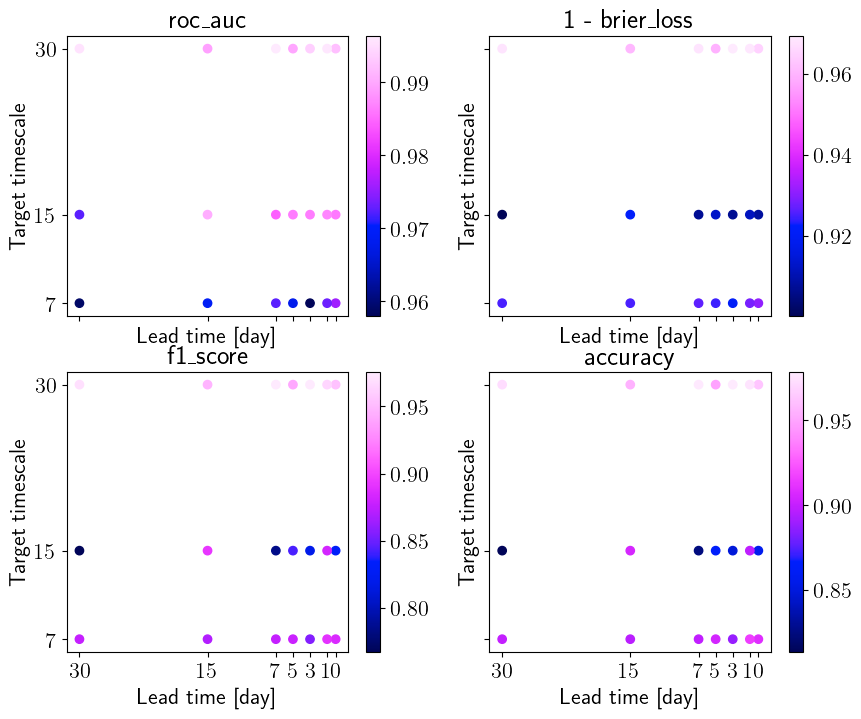

In [ ]:
x = full_pred.lag.values
y = full_pred.timescale.values
s = {
    'roc_auc': full_pred.roc_score.values,
    '1 - brier_loss': 1 - full_pred.brier_score_loss.values,
    'f1_score': full_pred.f1_score.values,
    'accuracy': full_pred.accuracy.values,
}
cmap = colormaps.cet_l_bmw1
fig, axes = plt.subplots(2, len(s) // 2, figsize=(10, 8), sharex=True, sharey=True)
for (scorename, s_), ax in zip(s.items(), axes.ravel()):
    im = ax.scatter(*np.meshgrid(x, y), c=s_.ravel(), cmap=cmap)
    ax.set_title(scorename)
    ax.set_xlabel('Lead time [day]')
    ax.set_xticks(np.unique(x))
    _ = ax.set_ylabel('Target timescale')
    _ = ax.set_yticks(np.unique(y))
    fig.colorbar(im, ax=ax)
ax.invert_xaxis()

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


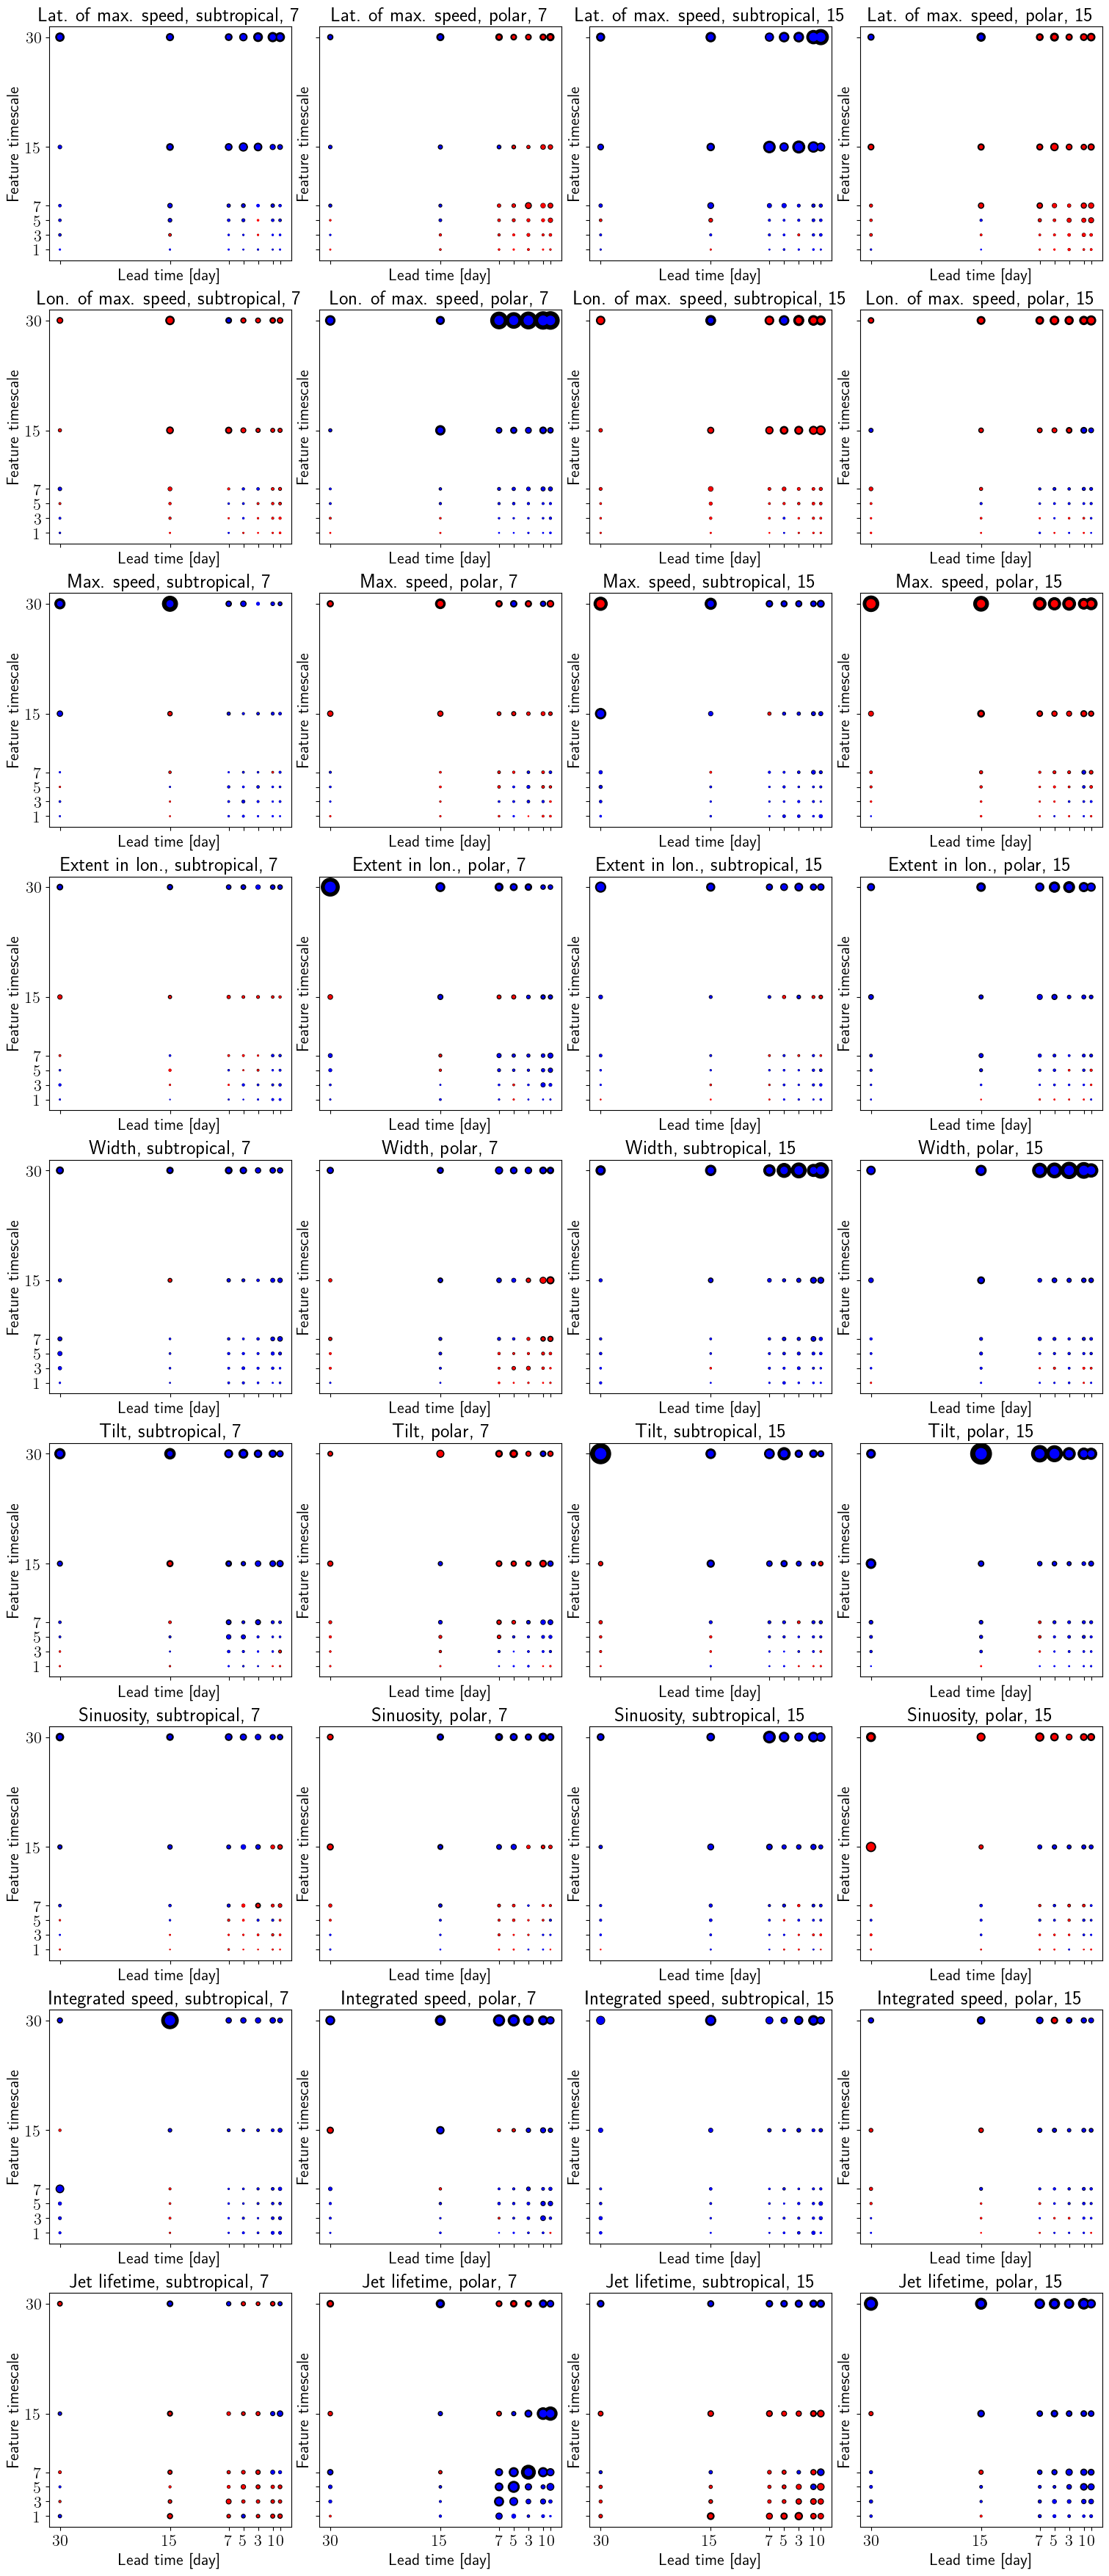

In [ ]:
x = shap_abs_mean_importances.lag.values
y = shap_abs_mean_importances.driver_timescale.values
fig, axes = plt.subplots(9, 4, figsize=(15, 35), constrained_layout=True, sharey=True, sharex=True)
target_timescales = [7, 15]
for varname, axs in zip(shap_abs_mean_importances.varname.values, axes):
    for (target_timescale, jet), ax in zip(product(target_timescales, shap_abs_mean_importances.jet.values), axs):
        s1 = permutation_importances.loc[varname, jet, :, target_timescale].values
        s2 = shap_abs_mean_importances.loc[varname, jet, :, target_timescale].values
        s3 = shap_correlations.loc[varname, jet, :, target_timescale].values
        ax.scatter(*np.meshgrid(x, y), s=s1 * 2000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
        ax.scatter(*np.meshgrid(x, y), s=s2 * 2000, c=np.sign(s3), cmap='bwr', vmin=-1, vmax=1)
        ax.set_xlabel('Lead time [day]')
        ax.set_xticks(np.unique(x))
        ax.set_ylabel('Feature timescale')
        ax.set_yticks(np.unique(y))
        ax.set_title(f'{PRETTIER_VARNAME[varname]}, {jet}, {target_timescale}')
ax.invert_xaxis()